### Part 2: Crop weed separation

In [1]:
# Import packages 
import os
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
plt.style.use('default')

#import tensorflow 
import tensorflow as tf

# import gzip to read data 
import gzip
import glob

#details about the images: 
from skimage.io import imread
from skimage.transform import resize,rotate
from skimage.util import invert
from IPython.display import Image

#import keras elements
import keras.backend as K
import keras
from keras import layers, activations
from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Layer


from small_Unet import *
import json

Using TensorFlow backend.


In [4]:
# download dataset 
# This dataset comprises various images :  
# and crop/weed plant type [annotations](annotations)
#Input images : field [images](images) 
Input_images = []
path='.\Crop_weed\images'
for im in glob.glob(path+"\*.png"):
    Input_images.append(im.split('\\')[3])
    
    
# vegetation segmentation [masks](masks)       
Masks = []
path1='.\Crop_weed\masks'
for im in glob.glob(path1+"\*.png"):
    Masks.append(im.split('\\')[3])
    


# crop/weed plant type [annotations](annotations)   
annotations= []
path2='.\Crop_weed\Annotations'
for im1 in glob.glob(path2+"\*.png"):
     annotations.append(im1.split('\\')[3])
    

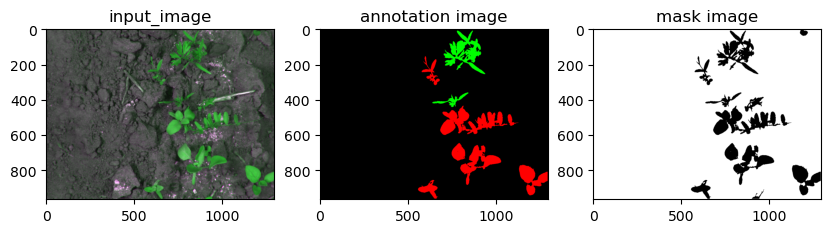

In [5]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input_image")
plt.imshow(imread(path+"/"+Input_images[2]))
plt.subplot(1,3,2)
plt.title("annotation image")
plt.imshow(imread(path2+"/"+annotations[2]))
plt.subplot(1,3,3)
plt.title("mask image")
plt.imshow(imread(path1+"/"+Masks[2]),cmap="gray")
plt.show()

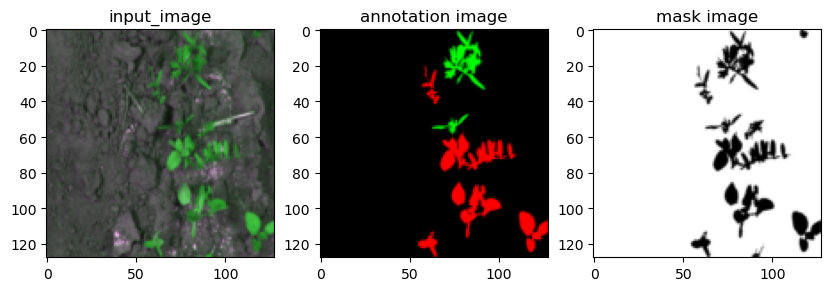

In [6]:
#for training speed, will resize it to 128, 128 
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input_image")
plt.imshow(resize(imread(path+"/"+Input_images[2]),(128,128)))
plt.subplot(1,3,2)
plt.title("annotation image")
plt.imshow(resize(imread(path2+"/"+annotations[2]),(128,128)))
plt.subplot(1,3,3)
plt.title("mask image")
plt.imshow(resize(imread(path1+"/"+Masks[2]),(128,128)),cmap="gray")
plt.show()

In [7]:
files=Input_images+Masks+annotations
#print(sorted(files))
with open('.//split_train_test.json') as data:
  datasets = json.load(data)

Train_data=datasets['train'] 
Test_data=datasets['test'] 

print("train_data is:",Train_data)
print("test_data is:",Train_data)

train_data is: [2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]
test_data is: [2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]


### Region Segmentation (crop weed segmentation)

In [8]:
#do not use for now

#modified based on https://github.com/keras-team/keras/issues/9395

#---------------------------------------------------------------------------------------------------------------------#
#generalized dice loss
#smooth variable is used to avoid division by zero or getting inf formula (zero/zero)
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=2):
    dice=0
    for index in range(numLabels):
        #dice -= dice_coef(y_true[:,index,:,:,:], y_pred[:,index,:,:,:])
        dice -= dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
    return dice
#---------------------------------------------------------------------------------------------------------------------#
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
   #num = K.sum(p0*g0, (0,1,2,3))
    num = K.sum(p0*g0, (0,1,2))
    #den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T
#---------------------------------------------------------------------------------------------------------------------#


### 1- Model design and preparation 

In [9]:
# Keras model Structure and architecture 
K.clear_session()

unet = small_Unet(labels=3,out_activation=None)  
l = layers.Reshape((128*128,3))(unet.output)
outs = layers.Activation("softmax")(l)

model = Model(inputs=unet.input,outputs=outs)

#model.compile(loss=dice_coef_multilabel,optimizer="rmsprop")
#model.compile(loss=tversky_loss,optimizer="rmsprop")
model.compile(loss="categorical_crossentropy",optimizer="rmsprop")

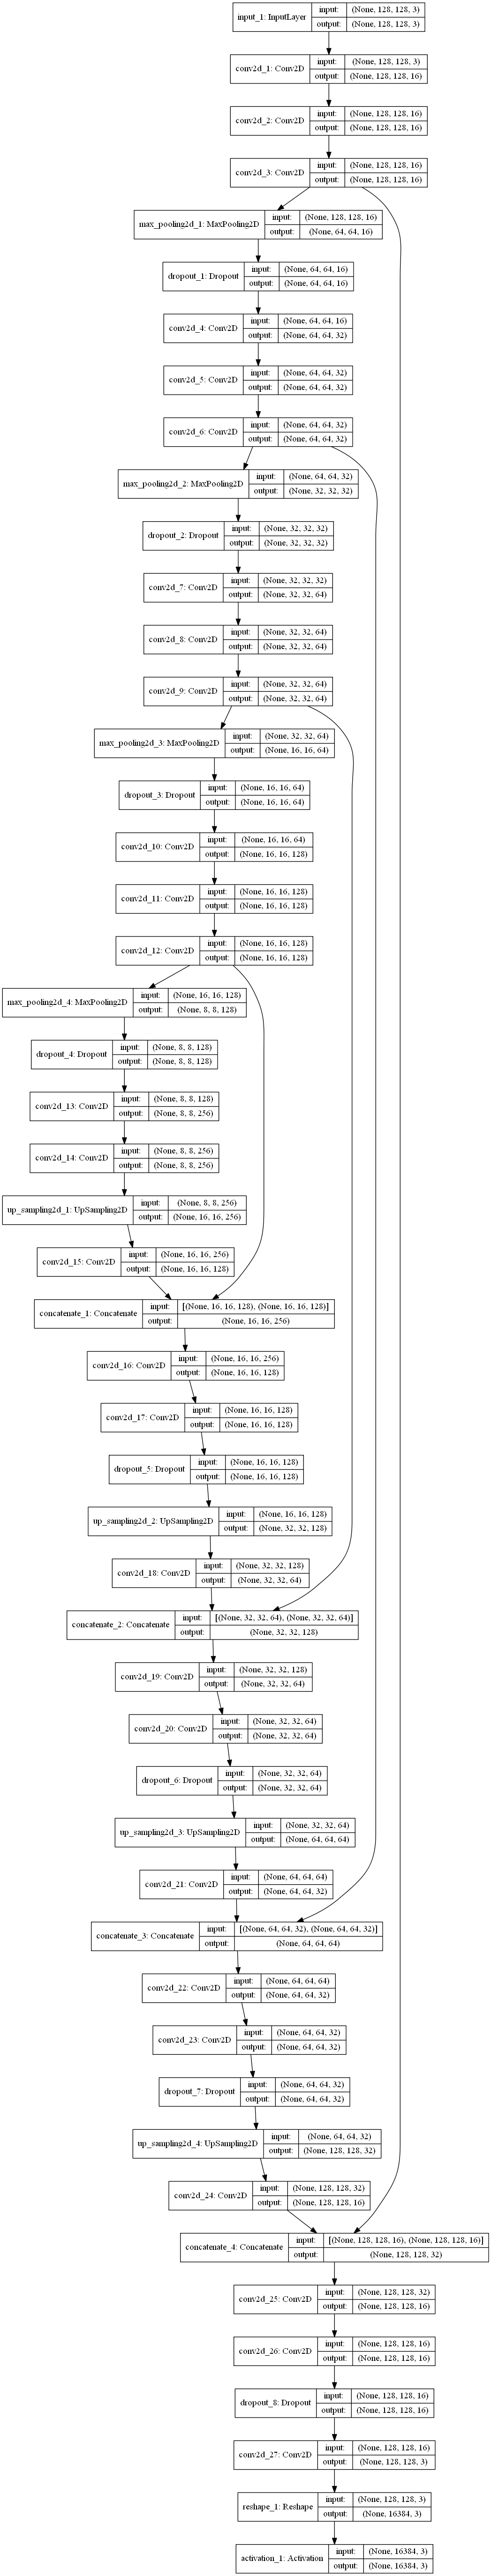

In [10]:
#alternative visualization of model structure
plot_model(model, to_file="model_plotweed.png", show_shapes=True, show_layer_names=True)

Image("model_plotweed.png")

### 2- Data preparation 

In [11]:
#read image into memory

train_x = []
train_y = []

for number in Train_data:
    
    img = load_img(path+'\\'+ str(number).zfill(3)+ "_image.png" ,target_size=(128,128))
    img = img_to_array(img)/255
    train_x.append(img)
    
    
    img = load_img(path2+'\\'+ str(number).zfill(3)+ "_annotation.png" ,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    y[:,:, 0] = weed
    y[:, :, 1] = crop
    
    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    
    train_y.append(y)
    

In [12]:
test_x = []
test_y = []

for number in Test_data:

    img = load_img(path+'\\'+ str(number).zfill(3)+"_image.png" ,target_size=(128,128))
    img = img_to_array(img)/255
    test_x.append(img)
    
    img = load_img(path2+'\\'+ str(number).zfill(3)+ "_annotation.png" ,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    
    y[:,:, 0] = weed
    y[:, :,1] = crop

    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    test_y.append(y)

    
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [13]:
#check shape
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(40, 128, 128, 3)
(40, 16384, 3)
(21, 128, 128, 3)
(21, 16384, 3)


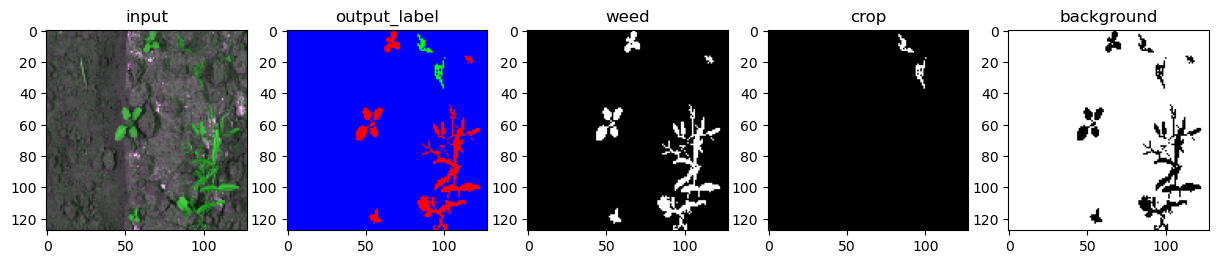

In [14]:
n = 13

plt.figure(figsize=(15,3))
plt.subplot(1,5,1)
plt.title("input")
plt.imshow(train_x[n])

plt.subplot(1,5,2)
plt.title("output_label")
img = np.reshape(train_y[n, :],(128,128,3))
plt.imshow(img,)

plt.subplot(1,5,3)
plt.title("weed")
img = np.reshape(train_y[n, :, 0],(128,128))
plt.imshow(img,cmap="gray")

plt.subplot(1,5,4)
plt.title("crop")
img = np.reshape(train_y[n, :, 1],(128,128))
plt.imshow(img,cmap="gray")

plt.subplot(1,5,5)
plt.title("background")
img = np.reshape(train_y[n, :, 2],(128,128))
plt.imshow(img,cmap="gray")

### 3- Training the model 

In [15]:
history = model.fit(train_x, train_y, batch_size=10, epochs=150, verbose=1,validation_data=(test_x,test_y))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 40 samples, validate on 21 samples
Epoch 1/150
40/40 [==============================] - 13s 327ms/step - loss: 1.2967 - val_loss: 1.1947
Epoch 2/150
40/40 [==============================] - 9s 229ms/step - loss: 1.3038 - val_loss: 1.1947
Epoch 3/150
40/40 [==============================] - 9s 228ms/step - loss: 1.2364 - val_loss: 1.1947
Epoch 4/150
40/40 [==============================] - 9s 230ms/step - loss: 1.2143 - val_loss: 1.1947
Epoch 5/150
40/40 [==============================] - 9s 231ms/step - loss: 1.2151 - val_loss: 1.1947
Epoch 6/150
40/40 [==============================] - 10s 242ms/step - loss: 1.2142 - val_loss: 1.1947
Epoch 7/150
40/40 [==============================] - 11s 272ms/step - loss: 1.2070 - val_loss: 1.1947
Epoch 8/150
40/40 [==============================] - 11s 280ms/step - loss: 1.2068 - val_loss: 1.1947
Epoch 9/150
40/40 [==============================

Epoch 75/150
40/40 [==============================] - 10s 255ms/step - loss: 0.1192 - val_loss: 0.1007
Epoch 76/150
40/40 [==============================] - 10s 259ms/step - loss: 0.1178 - val_loss: 0.0994
Epoch 77/150
40/40 [==============================] - 10s 257ms/step - loss: 0.1163 - val_loss: 0.1008
Epoch 78/150
40/40 [==============================] - 11s 270ms/step - loss: 0.1262 - val_loss: 0.1127
Epoch 79/150
40/40 [==============================] - 10s 261ms/step - loss: 0.1201 - val_loss: 0.1061
Epoch 80/150
40/40 [==============================] - 10s 258ms/step - loss: 0.1168 - val_loss: 0.0997
Epoch 81/150
40/40 [==============================] - 10s 262ms/step - loss: 0.1157 - val_loss: 0.1271
Epoch 82/150
40/40 [==============================] - 10s 256ms/step - loss: 0.1566 - val_loss: 0.0981
Epoch 83/150
40/40 [==============================] - 10s 258ms/step - loss: 0.1142 - val_loss: 0.0959
Epoch 84/150
40/40 [==============================] - 10s 258ms/step - lo

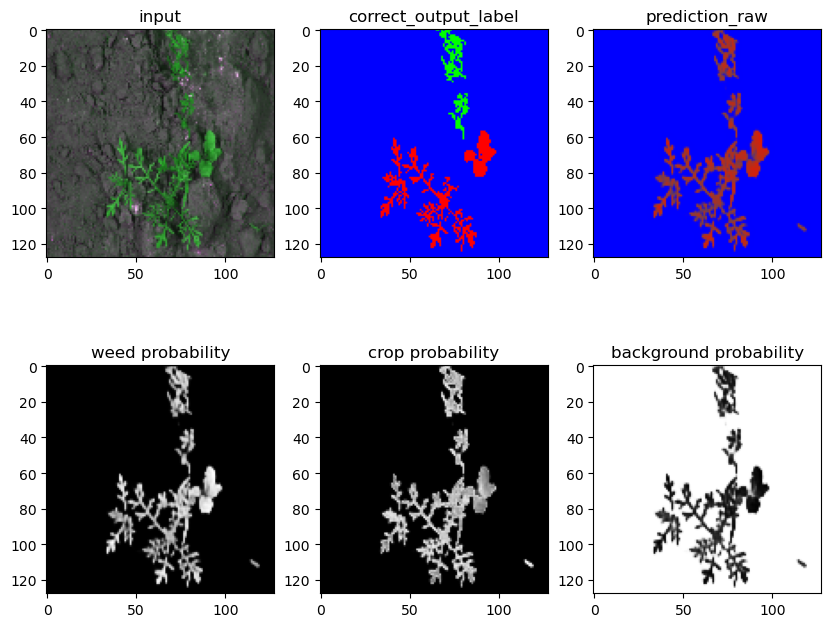

In [16]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 3

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")

Notes : 

Dropout is a technique used to prevent a model from overfitting

### Avoiding class imblance

38426.0
10319.0
606615


Text(0, 0.5, 'pixels number')

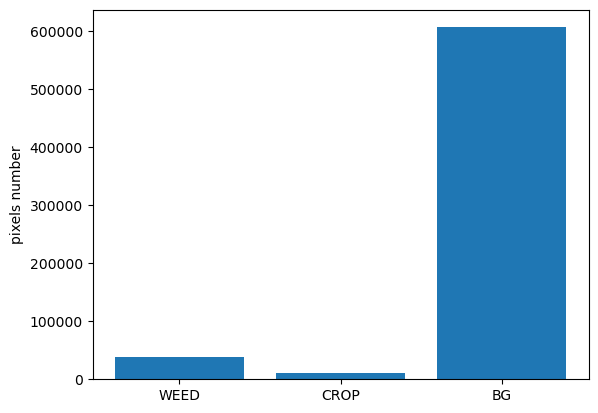

In [17]:
# First of all we calculate total pixel per label in train dataset

weed_pixel = 0
crop_pixel = 0
background_pixel = 0

for number in Train_data:

    img = load_img(path2+'\\'+ str(number).zfill(3)+ "_annotation.png" ,target_size=(128,128))
    img = img_to_array(img)/255

    weed = img[:,:,0]
    pix_w = np.sum(weed.flatten())
    weed_pixel += pix_w 
    crop = img[:,:,1]
    pix_C = np.sum(crop.flatten())
    crop_pixel += pix_C

    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1) * 1
    pix_b = np.sum(back.flatten())
    background_pixel += pix_b


print(weed_pixel)
print(crop_pixel)
print(background_pixel)

plt.bar(["WEED","CROP","BG"],[weed_pixel,crop_pixel,background_pixel])
plt.ylabel("pixels number")

In [18]:
class_weight = [background_pixel/weed_pixel, background_pixel/crop_pixel, 1]
print(class_weight)

[15.786576796960391, 58.78621959492199, 1]


In [19]:
#categorical crossentropy with losses

def weighted_categorical_crossentropy(weights):
    """ Args: * weights<ktensor|nparray|list>: crossentropy weights
        Returns: * weighted categorical crossentropy function
    """
    if isinstance(weights,list) or isinstance(np.ndarray): # check if it is list or arrary
        weights=K.variable(weights) # Numpy array, initial value of the tensor are the calculated weights

    def loss(target,output,from_logits=False): # define the new loss function
        if not from_logits: #from_logits=True means output values (generated by the model) are not normalized
            output /= tf.reduce_sum(output,len(output.get_shape()) - 1,True) # Computes the sum of elements across
            # dimensions of a tensor
            #The target is the correct class (y_true)
            # the output is the predicted class (y_pred)
            _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
            # K.epsilon() returns a float 
            # Converts the given value (K.epsilon()) to a Tensor
            output = tf.clip_by_value(output, _epsilon, 1. - _epsilon) #Clips tensor values to a specified min and max
            # the min is epsilon and the max is 1-epsilon
            # clip to prevent NaN's and Inf's
            weighted_losses = target * tf.log(output) * weights #
            #log Computes natural logarithm of x element-wise
            return - tf.reduce_sum(weighted_losses,len(output.get_shape()) - 1)
        else:
            raise ValueError('WeightedCategoricalCrossentropy: not valid with logits')
    return loss   

In [20]:
K.clear_session()

custom_loss = weighted_categorical_crossentropy(class_weight)

unet = small_Unet(labels=3,out_activation=None)  
l = layers.Reshape((128*128,3))(unet.output)
outs = layers.Activation("softmax")(l)

model = Model(inputs=unet.input,outputs=outs)

model.compile(loss=custom_loss,optimizer="rmsprop")

In [21]:
history = model.fit(train_x, train_y, batch_size=10, epochs=150, verbose=1,validation_data=(test_x,test_y))

Train on 40 samples, validate on 21 samples
Epoch 1/150
40/40 [==============================] - 13s 332ms/step - loss: 3.0500 - val_loss: 3.0475
Epoch 2/150
40/40 [==============================] - 9s 235ms/step - loss: 2.9748 - val_loss: 2.8913
Epoch 3/150
40/40 [==============================] - 9s 227ms/step - loss: 2.7907 - val_loss: 2.5930
Epoch 4/150
40/40 [==============================] - 9s 228ms/step - loss: 2.5323 - val_loss: 2.3999
Epoch 5/150
40/40 [==============================] - 9s 226ms/step - loss: 2.3885 - val_loss: 2.4763
Epoch 6/150
40/40 [==============================] - 9s 227ms/step - loss: 2.2690 - val_loss: 1.9544
Epoch 7/150
40/40 [==============================] - 9s 228ms/step - loss: 2.0418 - val_loss: 1.8050
Epoch 8/150
40/40 [==============================] - 9s 229ms/step - loss: 1.9975 - val_loss: 2.1731
Epoch 9/150
40/40 [==============================] - 9s 230ms/step - loss: 2.1637 - val_loss: 1.7620
Epoch 10/150
40/40 [==========================

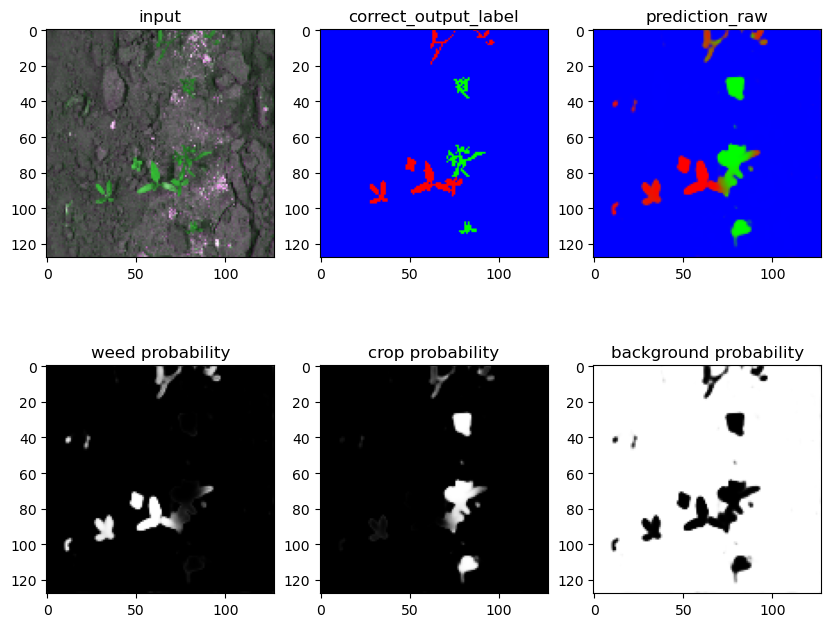

In [22]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 15

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")